In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import torch
import torch.nn.functional as F
from networks.vision_trans import ConViT
from dataset_v2 import CANDataset #Using v2 if not include Timestamp
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from util import TwoCropTransform, AverageMeter
from torch.utils.data import DataLoader

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [5]:
# # Not include Timestamp
can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# train_dataset = CANDataset(root_dir='../data/Car-Hacking/all_features/v2/TFRecord_w32_s32/2', window_size=32, is_train=True,
#                     transform=TwoCropTransform(can_transform))
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

In [6]:
test_dataset = CANDataset(root_dir='../data/Car-Hacking/all_features/v2/TFRecord_w32_s32/2', window_size=32, is_train=False, transform=can_transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [12]:
model = ConViT(n_classes=5, emb_size=256)

save_path = '../save/CAN_models/UniconViT/UniconViT_CAN_resnet50_lr_0.0005_decay_0.0001_bsz_64_temp_0.07_mixup_lambda_0.5_trial_can_ConViT_cosine_warm/'
# ./save/CAN_models/UniconViT/UniconViT_CAN_resnet50_lr_0.0005_decay_0.0001_bsz_64_temp_0.07_mixup_lambda_0.5_trial_can_ConViT_cosine_warm/ckpt_epoch_63.pth
ckpt_epoch = 93

model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)


<All keys matched successfully>

In [13]:
import numpy as np
import tqdm
import torch
from sklearn.metrics import accuracy_score, classification_report

total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)

model = model.cuda()
model.eval()

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.cuda(non_blocking=True)
        
        outputs = model(images, use_projection=False)
        
        _, pred = torch.max(outputs, 1)
        
        pred = pred.cpu().numpy()
        labels = labels.cpu().numpy()
        
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)

accuracy = accuracy_score(total_label, total_pred) 
report = classification_report(total_label, total_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


100%|██████████| 2428/2428 [01:35<00:00, 25.50it/s]


Accuracy: 0.9978821060491944
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     95882
           1       1.00      1.00      1.00     10190
           2       1.00      0.99      0.99     12102
           3       1.00      1.00      1.00     17759
           4       1.00      1.00      1.00     19410

    accuracy                           1.00    155343
   macro avg       1.00      1.00      1.00    155343
weighted avg       1.00      1.00      1.00    155343



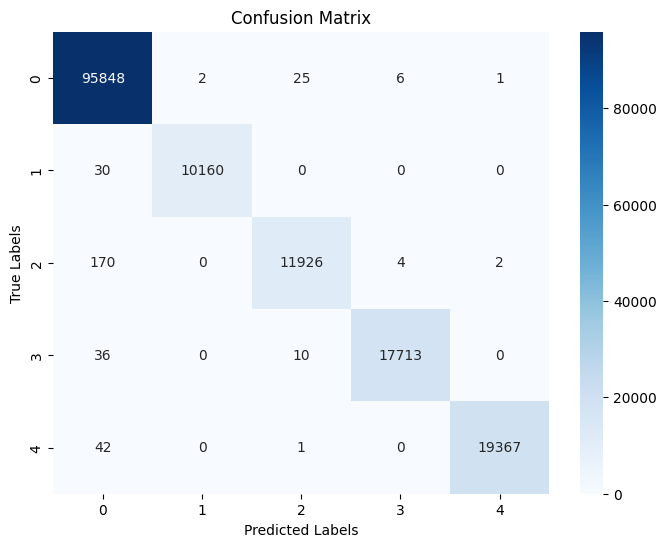

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(total_label, total_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(total_label), yticklabels=np.unique(total_label))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
